# [Teach Old Dog New Tricks - Train Facial identification model to understand Facial Emotion](https://www.dlology.com/blog/teach-old-dog-new-tricks-train-facial-identification-model-to-understand-facial-emotion/)
You can download the [fer2013](https://www.kaggle.com/c/challenges-in-representation-learning-facial-expression-recognition-challenge/data) dataset from Kaggle. Each picture is 48x48 pixel grayscale images of faces.

Import packages,
realize how we import keras from tensorflow 

`tensorflow.python.keras`

This is new in tensorflow version 1.4.0

In [1]:
from tensorflow.python.keras import models
from tensorflow.python.keras import layers
from tensorflow.python.keras.preprocessing import image
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
import numpy as np
import pandas as pd
import sys
from PIL import Image
import os
import shutil
from keras_vggface.vggface import VGGFace
import cv2

tf.__version__

c:\users\hasee\appdata\local\programs\python\python35\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.4.0'

## Build Keras model
We are leveraging the pre-trained VGG-Face2 model's convolution layers. aka the "convolutional base" of the model. Then we add our own classifier fully connected layers to do emotion classification. 

Note that since we don't want to touch the parameters pre-trained in the "convolutional base", so we set them as not trainable. Want to go deeper how this model works? Check out this great [jupyter notebook](https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/5.3-using-a-pretrained-convnet.ipynb) by the creator of Keras.

In [2]:
conv_base = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3),
                                pooling='avg')  # pooling: None, avg or max
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
conv_base.trainable = False

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vggface_resnet50 (Model)     (None, 2048)              23561152  
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 1799      
Total params: 24,087,495
Trainable params: 4,988,935
Non-trainable params: 19,098,560
_________________________________________________________________


In [3]:
# set 'activation_46' and following layers trainable
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'activation_46':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [4]:
for layer in conv_base.layers:
    if layer.trainable:
        print(layer.name)

activation_46
conv5_3_1x1_reduce
conv5_3_1x1_reduce/bn
activation_47
conv5_3_3x3
conv5_3_3x3/bn
activation_48
conv5_3_1x1_increase
conv5_3_1x1_increase/bn
add_16
activation_49
avg_pool
global_average_pooling2d_1


In [5]:
conv_base.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 224, 224, 3)   0                                            
____________________________________________________________________________________________________
conv1/7x7_s2 (Conv2D)            (None, 112, 112, 64)  9408        input_1[0][0]                    
____________________________________________________________________________________________________
conv1/7x7_s2/bn (BatchNormalizat (None, 112, 112, 64)  256         conv1/7x7_s2[0][0]               
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 112, 112, 64)  0           conv1/7x7_s2/bn[0][0]            
___________________________________________________________________________________________

In [5]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

## Keras model to TF estimator
`model_dir` will be our location to store trained tensorflow models. Training progress can be viewed by TensorBoard.

I found that I have to specify the full path, otherwise, Tensorflow will complain about it later during training.

In [6]:
model_dir = os.path.join(os.getcwd(), "models//emotion_vgg16").replace("//", "\\")
os.makedirs(model_dir, exist_ok=True)
print("model_dir: ",model_dir)
est_emotion = tf.keras.estimator.model_to_estimator(keras_model=model,
                                                    model_dir=model_dir)

model_dir:  E:\SW_WS\Python_SW\face_classification\src\models\emotion_vgg16
INFO:tensorflow:Using the Keras model from memory.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_num_worker_replicas': 1, '_num_ps_replicas': 0, '_keep_checkpoint_every_n_hours': 10000, '_service': None, '_session_config': None, '_save_checkpoints_secs': 600, '_task_id': 0, '_task_type': 'worker', '_keep_checkpoint_max': 5, '_model_dir': 'E:\\SW_WS\\Python_SW\\face_classification\\src\\models\\emotion_vgg16', '_master': '', '_tf_random_seed': None, '_save_checkpoints_steps': None, '_log_step_count_steps': 100, '_save_summary_steps': 100, '_is_chief': True, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000002B4DC416F98>}


The input_name is the model's input layer name, we will need it later when building Input function for your estimator. More on that in Input function section below.

In [7]:
# input layer name
input_name = model.input_names[0]
input_name

'input_1'

In [7]:
dataset_path = "./datasets/fer2013/fer2013.csv"
data = pd.read_csv(dataset_path)
pixels = data['pixels'].tolist()
src_size = (48, 48)

faces = []
for pixel_sequence in pixels:
    face = [int(pixel) for pixel in pixel_sequence.split(' ')]
    face = np.asarray(face).reshape(src_size)
    faces.append(face.astype('float32'))
faces = np.asarray(faces)

In [8]:
data['emotion'].value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

In [9]:
# one hot encoding
# (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral)
emotions = pd.get_dummies(data['emotion']).as_matrix()

In [43]:
emotions[:10]

array([[1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0]], dtype=uint8)

In [10]:
def split_data(x, y, validation_split=.2):
    num_samples = len(x)
    num_train_samples = int((1 - validation_split)*num_samples)
    train_x = x[:num_train_samples]
    train_y = y[:num_train_samples]
    val_x = x[num_train_samples:]
    val_y = y[num_train_samples:]
    train_data = (train_x, train_y)
    val_data = (val_x, val_y)
    return train_data, val_data

train_data, val_data = split_data(faces, emotions)

In [8]:
base_dir = './data/emotion'
os.makedirs(base_dir, exist_ok=True)
path_tfrecords_train = os.path.join(base_dir, "train.tfrecords")
path_tfrecords_test = os.path.join(base_dir, "test.tfrecords")


Helper-function for printing the conversion progress.

In [12]:
def print_progress(count, total):
    # Percentage completion.
    pct_complete = float(count) / total

    # Status-message.
    # Note the \r which means the line should overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

Helper-function for wrapping an integer so it can be saved to the TFRecord file.

In [13]:
def wrap_int64(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

Helper-function for wrapping a list of integer so it can be saved to the TFRecord file.

In [14]:
def wrap_int64_list(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=value))

Helper-function for wrapping raw bytes so they can be saved to the TFRecord file.

In [15]:
def wrap_bytes(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

Function for reading images from disk and writing them along with the class-labels to a TFRecord file.

In [16]:
def convert(image_arrays, labels, out_path, size=(224,224)):
    # Args:
    # image_paths   List of numpy image arrays.
    # labels        Class-labels for the images.
    # out_path      File-path for the TFRecords output file.    
    print("Converting: " + out_path)
    # Number of images. Used when printing the progress.
    num_images = len(image_arrays)    
    # Open a TFRecordWriter for the output-file.
    with tf.python_io.TFRecordWriter(out_path) as writer:
        # Iterate over all the image-paths and class-labels.
        for i, (img, label) in enumerate(zip(image_arrays, labels)):
            # Print the percentage-progress.
            print_progress(count=i, total=num_images-1)
            # resize the image array to desired size
            img = cv2.resize(img.astype('uint8'), size)    
            # Turn gray to color.
            img = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
            # Convert the image to raw bytes.
            img_bytes = img.tostring()
            # Create a dict with the data we want to save in the
            # TFRecords file. You can add more relevant data here.
            data = \
                {
                    'image': wrap_bytes(img_bytes),
                    'label': wrap_int64_list(label)
                }
            # Wrap the data as TensorFlow Features.
            feature = tf.train.Features(feature=data)
            # Wrap again as a TensorFlow Example.
            example = tf.train.Example(features=feature)
            # Serialize the data.
            serialized = example.SerializeToString()        
            # Write the serialized data to the TFRecords file.
            writer.write(serialized)

In [18]:
convert(image_arrays=train_data[0],
        labels=train_data[1],
        out_path=path_tfrecords_train)
convert(image_arrays=val_data[0],
        labels=val_data[1],
        out_path=path_tfrecords_test)

---
Converting: ./data/emotion\train.tfrecords
A
- Progress: 0.0%ERROR! Session/line number was not unique in database. History logging moved to new session 929
- Progress: 100.0%Converting: ./data/emotion\test.tfrecords
A
- Progress: 100.0%

## Input function
When we train our model, we'll need a function that reads the input image and labels and returns the image data and labels. Estimators require that you create a function of the following format:
````
def input_fn():
    ...<code>...
    return ({ 'input_1':[ImagesValues]},
            [ImageTypeLogit])
```
The return value must be a two-element tuple organized as follows: :

- The first element must be a dictionary in which each input feature is a key, and then a list of values for the training batch.
- The second element is a list of labels for the training batch.
### Arguments
- **filenames**, TF-record file name
- **perform_shuffle=False**, Useful when training, reads batch_size records, then shuffles (randomizes) their order.
- **repeat_count=1**, Useful when training, repeat the input data several times for each epoch
- **batch_size=1**, Reads batch_size records at a time

In [30]:
def imgs_input_fn(filenames, perform_shuffle=False, 
                  repeat_count=1, batch_size=1):
    def _parse_function(serialized):
        features = \
        {
            'image': tf.FixedLenFeature([], tf.string),
            'label': tf.FixedLenFeature([7], tf.int64)
        }
        # Parse the serialized data so we get a dict with our data.
        parsed_example = tf.parse_single_example(serialized=serialized,
                                                 features=features)
        # Get the image as raw bytes.
        image_shape = tf.stack([224, 224, 3])
        image_raw = parsed_example['image']
        label = tf.cast(parsed_example['label'], tf.float32)
        # Decode the raw bytes so it becomes a tensor with type.
        image = tf.decode_raw(image_raw, tf.uint8)
        image = tf.cast(image, tf.float32)
        image = tf.reshape(image, image_shape)
        image = tf.subtract(image, 116.779) # Zero-center by mean pixel
        image = tf.reverse(image, axis=[2]) # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), label
        return d
    
    dataset = tf.data.TFRecordDataset(filenames=filenames)
    # Parse the serialized data in the TFRecords files.
    # This returns TensorFlow tensors for the image and labels.
    dataset = dataset.map(_parse_function)
    if perform_shuffle:
        # Randomizes input using a window of 256 elements (read into memory)
        dataset = dataset.shuffle(buffer_size=256)
    dataset = dataset.repeat(repeat_count)  # Repeats dataset this # times
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels


## Look at the input function output
Looks like color channels 'RGB' has changed to 'BGR' and shape resized to (224, 224) correctly for our model. That is the input format the VGGFace's "convolutional base" is expecting.

batch input shape: (20, 224, 224, 3)
batch output shape: (20, 7)


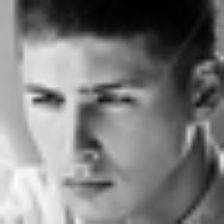

In [31]:
next_batch = imgs_input_fn(path_tfrecords_test, perform_shuffle=True, batch_size=20)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0]['input_1']
y_d = first_batch[1]
print("batch input shape: {}".format(x_d.shape))
print("batch output shape: {}".format(y_d.shape))
img = image.array_to_img(x_d[8])
img

In [32]:
x_d[8]

array([[[ 53.221    ,  53.221    ,  53.221    ],
        [ 53.221    ,  53.221    ,  53.221    ],
        [ 53.221    ,  53.221    ,  53.221    ],
        ...,
        [  3.2210007,   3.2210007,   3.2210007],
        [  2.2210007,   2.2210007,   2.2210007],
        [  2.2210007,   2.2210007,   2.2210007]],

       [[ 53.221    ,  53.221    ,  53.221    ],
        [ 53.221    ,  53.221    ,  53.221    ],
        [ 53.221    ,  53.221    ,  53.221    ],
        ...,
        [  3.2210007,   3.2210007,   3.2210007],
        [  2.2210007,   2.2210007,   2.2210007],
        [  2.2210007,   2.2210007,   2.2210007]],

       [[ 53.221    ,  53.221    ,  53.221    ],
        [ 53.221    ,  53.221    ,  53.221    ],
        [ 53.221    ,  53.221    ,  53.221    ],
        ...,
        [  3.2210007,   3.2210007,   3.2210007],
        [  2.2210007,   2.2210007,   2.2210007],
        [  2.2210007,   2.2210007,   2.2210007]],

       ...,

       [[ 79.221    ,  79.221    ,  79.221    ],
        [ 7

### tf.estimator.train_and_evaluate

TensorFlow release 1.4 also introduces the utility function **tf.estimator.train_and_evaluate**, which simplifies training, evaluation, and exporting Estimator models. This function enables distributed execution for training and evaluation, while still supporting local execution.

Notice that the train was build on previous training result when we call the `est_emotion.train()`

In [16]:
train_spec = tf.estimator.TrainSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_train,
                                                                   perform_shuffle=True,
                                                                   repeat_count=5,
                                                                   batch_size=20), 
                                    max_steps=500)
eval_spec = tf.estimator.EvalSpec(input_fn=lambda: imgs_input_fn(path_tfrecords_test,
                                                                 perform_shuffle=False,
                                                                 batch_size=1))

import time
start_time = time.time()
tf.estimator.train_and_evaluate(est_emotion, train_spec, eval_spec)
print("--- %s seconds ---" % (time.time() - start_time))

INFO:tensorflow:Running training and evaluation locally (non-distributed).
INFO:tensorflow:Start train and evaluate loop. The evaluate will happen after 600 secs (eval_spec.throttle_secs) or training is finished.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Restoring parameters from E:\SW_WS\Python_SW\face_classification\src\models\emotion_vgg16/
INFO:tensorflow:Saving checkpoints for 1 into E:\SW_WS\Python_SW\face_classification\src\models\emotion_vgg16\model.ckpt.
INFO:tensorflow:loss = 4.5533004, step = 1
INFO:tensorflow:global_step/sec: 6.99165
INFO:tensorflow:loss = 1.4638567, step = 101 (14.302 sec)
INFO:tensorflow:global_step/sec: 7.15022
INFO:tensorflow:loss = 1.1486661, step = 201 (13.987 sec)
INFO:tensorflow:global_step/sec: 7.17622
INFO:tensorflow:loss = 1.2883472, step = 301 (13.934 sec)
INFO:tensorflow:global_step/sec: 7.27774
INFO:tensorflow:loss = 1.4515326, step = 401 (13.742 sec)
INFO:tensorflow:Saving checkpoints for 500 into E:\SW_WS\Python_SW\face_cla

## Predict
To predict we can set the `labels` to None because that is what we will be predicting.

Here we only predict the first 10 images in the test_files.

In [25]:
def predict_imgs_input_fn(filenames, batch_size=1):
    def _parse_function(filename, label):
        image_string = tf.read_file(filename)
        image = tf.image.decode_image(image_string, channels=3)
        image.set_shape([None, None, None])
        image = tf.image.resize_images(image, [224, 224])
        image = tf.subtract(image, 116.779) # Zero-center by mean pixel
        image.set_shape([224, 224, 3])
        image = tf.reverse(image, axis=[2]) # 'RGB'->'BGR'
        d = dict(zip([input_name], [image])), label
        return d
    labels = [0]*len(filenames)
    labels=np.array(labels)
    # Expand the shape of "labels" if necessory
    if len(labels.shape) == 1:
        labels = np.expand_dims(labels, axis=1)
    filenames = tf.constant(filenames)
    labels = tf.constant(labels)
    labels = tf.cast(labels, tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(_parse_function)
    dataset = dataset.batch(batch_size)  # Batch size to use
    iterator = dataset.make_one_shot_iterator()
    batch_features, batch_labels = iterator.get_next()
    return batch_features, batch_labels


In [27]:
test_files = ["./data/small.jpg"]

In [28]:
predict_results = est_emotion.predict(
    input_fn=lambda: predict_imgs_input_fn(test_files[:1],
                                   batch_size=1))

In [29]:
predict_logits = []
for prediction in predict_results:
    predict_logits.append(prediction['dense_2'])
predict_logits[0].argmax()

INFO:tensorflow:Restoring parameters from E:\SW_WS\Python_SW\face_classification\src\models\emotion_vgg16\model.ckpt-500


6

## Predict all validation data

In [20]:
predict_val_results = est_emotion.predict(
    input_fn=lambda: imgs_input_fn(path_tfrecords_test,
                                     perform_shuffle=False,
                                     batch_size=20))
predict_val_logits = []
for prediction in predict_val_results:
    predict_val_logits.append(prediction['dense_2'])

INFO:tensorflow:Restoring parameters from E:\SW_WS\Python_SW\face_classification\src\models\emotion_vgg16\model.ckpt-500


INFO:tensorflow:Restoring parameters from E:\SW_WS\Python_SW\face_classification\src\models\emotion_vgg16\model.ckpt-500


### Check the prediction result

In [43]:
predicted_labels = [logits.argmax() for logits in predict_val_logits[:500]]

In [42]:
next_batch = imgs_input_fn(path_tfrecords_test, perform_shuffle=False, batch_size=500)
with tf.Session() as sess:
    first_batch = sess.run(next_batch)
x_d = first_batch[0]['input_1']
y_d = first_batch[1]
print("batch input shape: {}".format(x_d.shape))
print("batch output shape: {}".format(y_d.shape))

actual_labels = [logits.argmax() for logits in y_d]

batch input shape: (500, 224, 224, 3)
batch output shape: (500, 7)


In [44]:
sum(1 for x,y in zip(actual_labels,predicted_labels) if x == y) / len(actual_labels)

0.562